In [2]:
import tensorflow as tf
from keras import models , layers, optimizers , callbacks
import matplotlib.pyplot as plt



In [3]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/darre/OneDrive/Desktop/Darren/College Stuff/potato-disease-detection/Datasets/PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=(BATCH_SIZE))

Found 2152 files belonging to 3 classes.


In [25]:
class_names=dataset.class_names

In [5]:
for image_batch ,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.shape)
    

(32, 256, 256, 3)
(32,)


In [6]:
def get_dataset_partitions(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    if(shuffle):
        ds=ds.shuffle(shuffle_size,seed=12)
        train_size=int(train_split*len(ds))
        val_size=int(val_split*len(ds))
        train_ds=ds.take(train_size)
        val_ds=ds.skip(train_size).take(val_size)
        test_ds=ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [7]:
train_ds,val_ds,test_ds=get_dataset_partitions(dataset)


In [8]:
len(train_ds)


54

In [9]:
len(val_ds)

6

In [10]:
len(test_ds)

8

In [11]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [12]:
resize_and_rescale=tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])


In [13]:
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
])

In [14]:
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=(IMAGE_SIZE,IMAGE_SIZE)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=(IMAGE_SIZE,IMAGE_SIZE)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=(IMAGE_SIZE,IMAGE_SIZE)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=(IMAGE_SIZE,IMAGE_SIZE)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=(IMAGE_SIZE,IMAGE_SIZE)),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])

model.build(input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS))

In [15]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [31]:
lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1
)

# Early stopping
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model with callbacks
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[lr_scheduler, early_stopping]
)


Epoch 1/50
54/54 [==============================] - 98s 2s/step - loss: 0.1370 - accuracy: 0.9525 - val_loss: 0.1690 - val_accuracy: 0.9167 - lr: 1.0000e-05
Epoch 2/50
54/54 [==============================] - 103s 2s/step - loss: 0.1195 - accuracy: 0.9589 - val_loss: 0.1637 - val_accuracy: 0.9219 - lr: 1.0000e-05
Epoch 3/50
54/54 [==============================] - 104s 2s/step - loss: 0.1105 - accuracy: 0.9595 - val_loss: 0.1650 - val_accuracy: 0.9219 - lr: 1.0000e-05
Epoch 4/50
54/54 [==============================] - 106s 2s/step - loss: 0.1062 - accuracy: 0.9589 - val_loss: 0.1642 - val_accuracy: 0.9271 - lr: 1.0000e-05
Epoch 5/50
54/54 [==============================] - 107s 2s/step - loss: 0.1093 - accuracy: 0.9583 - val_loss: 0.1587 - val_accuracy: 0.9271 - lr: 1.0000e-05
Epoch 6/50
54/54 [==============================] - 110s 2s/step - loss: 0.1028 - accuracy: 0.9572 - val_loss: 0.1655 - val_accuracy: 0.9271 - lr: 1.0000e-05
Epoch 7/50
54/54 [==============================] - 1

In [32]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 3s 326ms/step - loss: 0.1609 - accuracy: 0.9219


In [33]:
scores


[0.16091108322143555, 0.921875]

In [35]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

In [36]:
range(EPOCHS)

range(0, 50)

Text(0.5, 1.0, 'Traing and Validation loss')

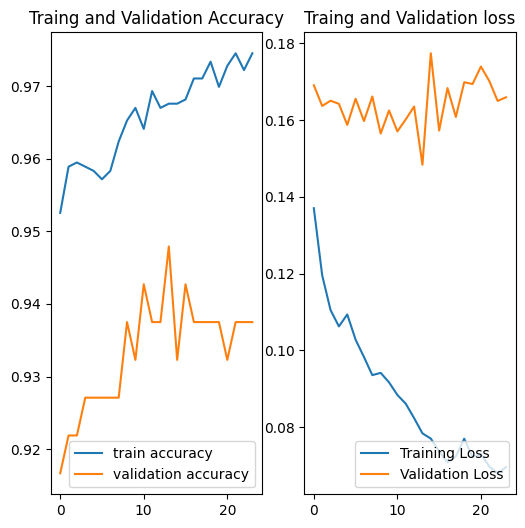

In [38]:
plt.figure(figsize=(6,6))
plt.subplot(1,2,1)
plt.plot(range(24),acc,label="train accuracy")
plt.plot(range(24),val_acc,label="validation accuracy")
plt.legend(loc='lower right')
plt.title('Traing and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(24),loss,label="Training Loss")
plt.plot(range(24),val_loss,label="Validation Loss")
plt.legend(loc='lower right')
plt.title('Traing and Validation loss')


actual Potato___Early_blight
1/1 [==============================] - 0s 482ms/step
predicted label:  Potato___Early_blight


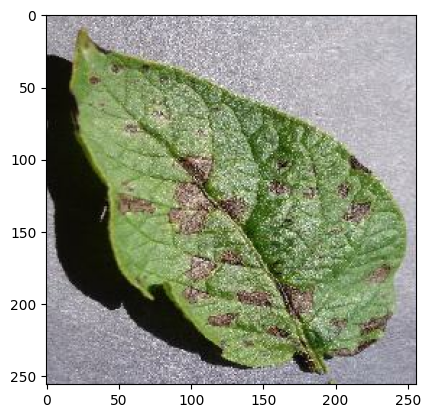

In [26]:
import numpy as np
for image_batch,label_batch in test_ds.take(1):
    first_image=image_batch[0].numpy().astype('uint8')
    first_label=label_batch[0].numpy()
    plt.imshow(first_image)
    print("actual",class_names[first_label])
    batch_prediction=model.predict(image_batch)
    print('predicted label: ' ,class_names[np.argmax(batch_prediction[0])])



In [27]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(img)
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 30ms/step


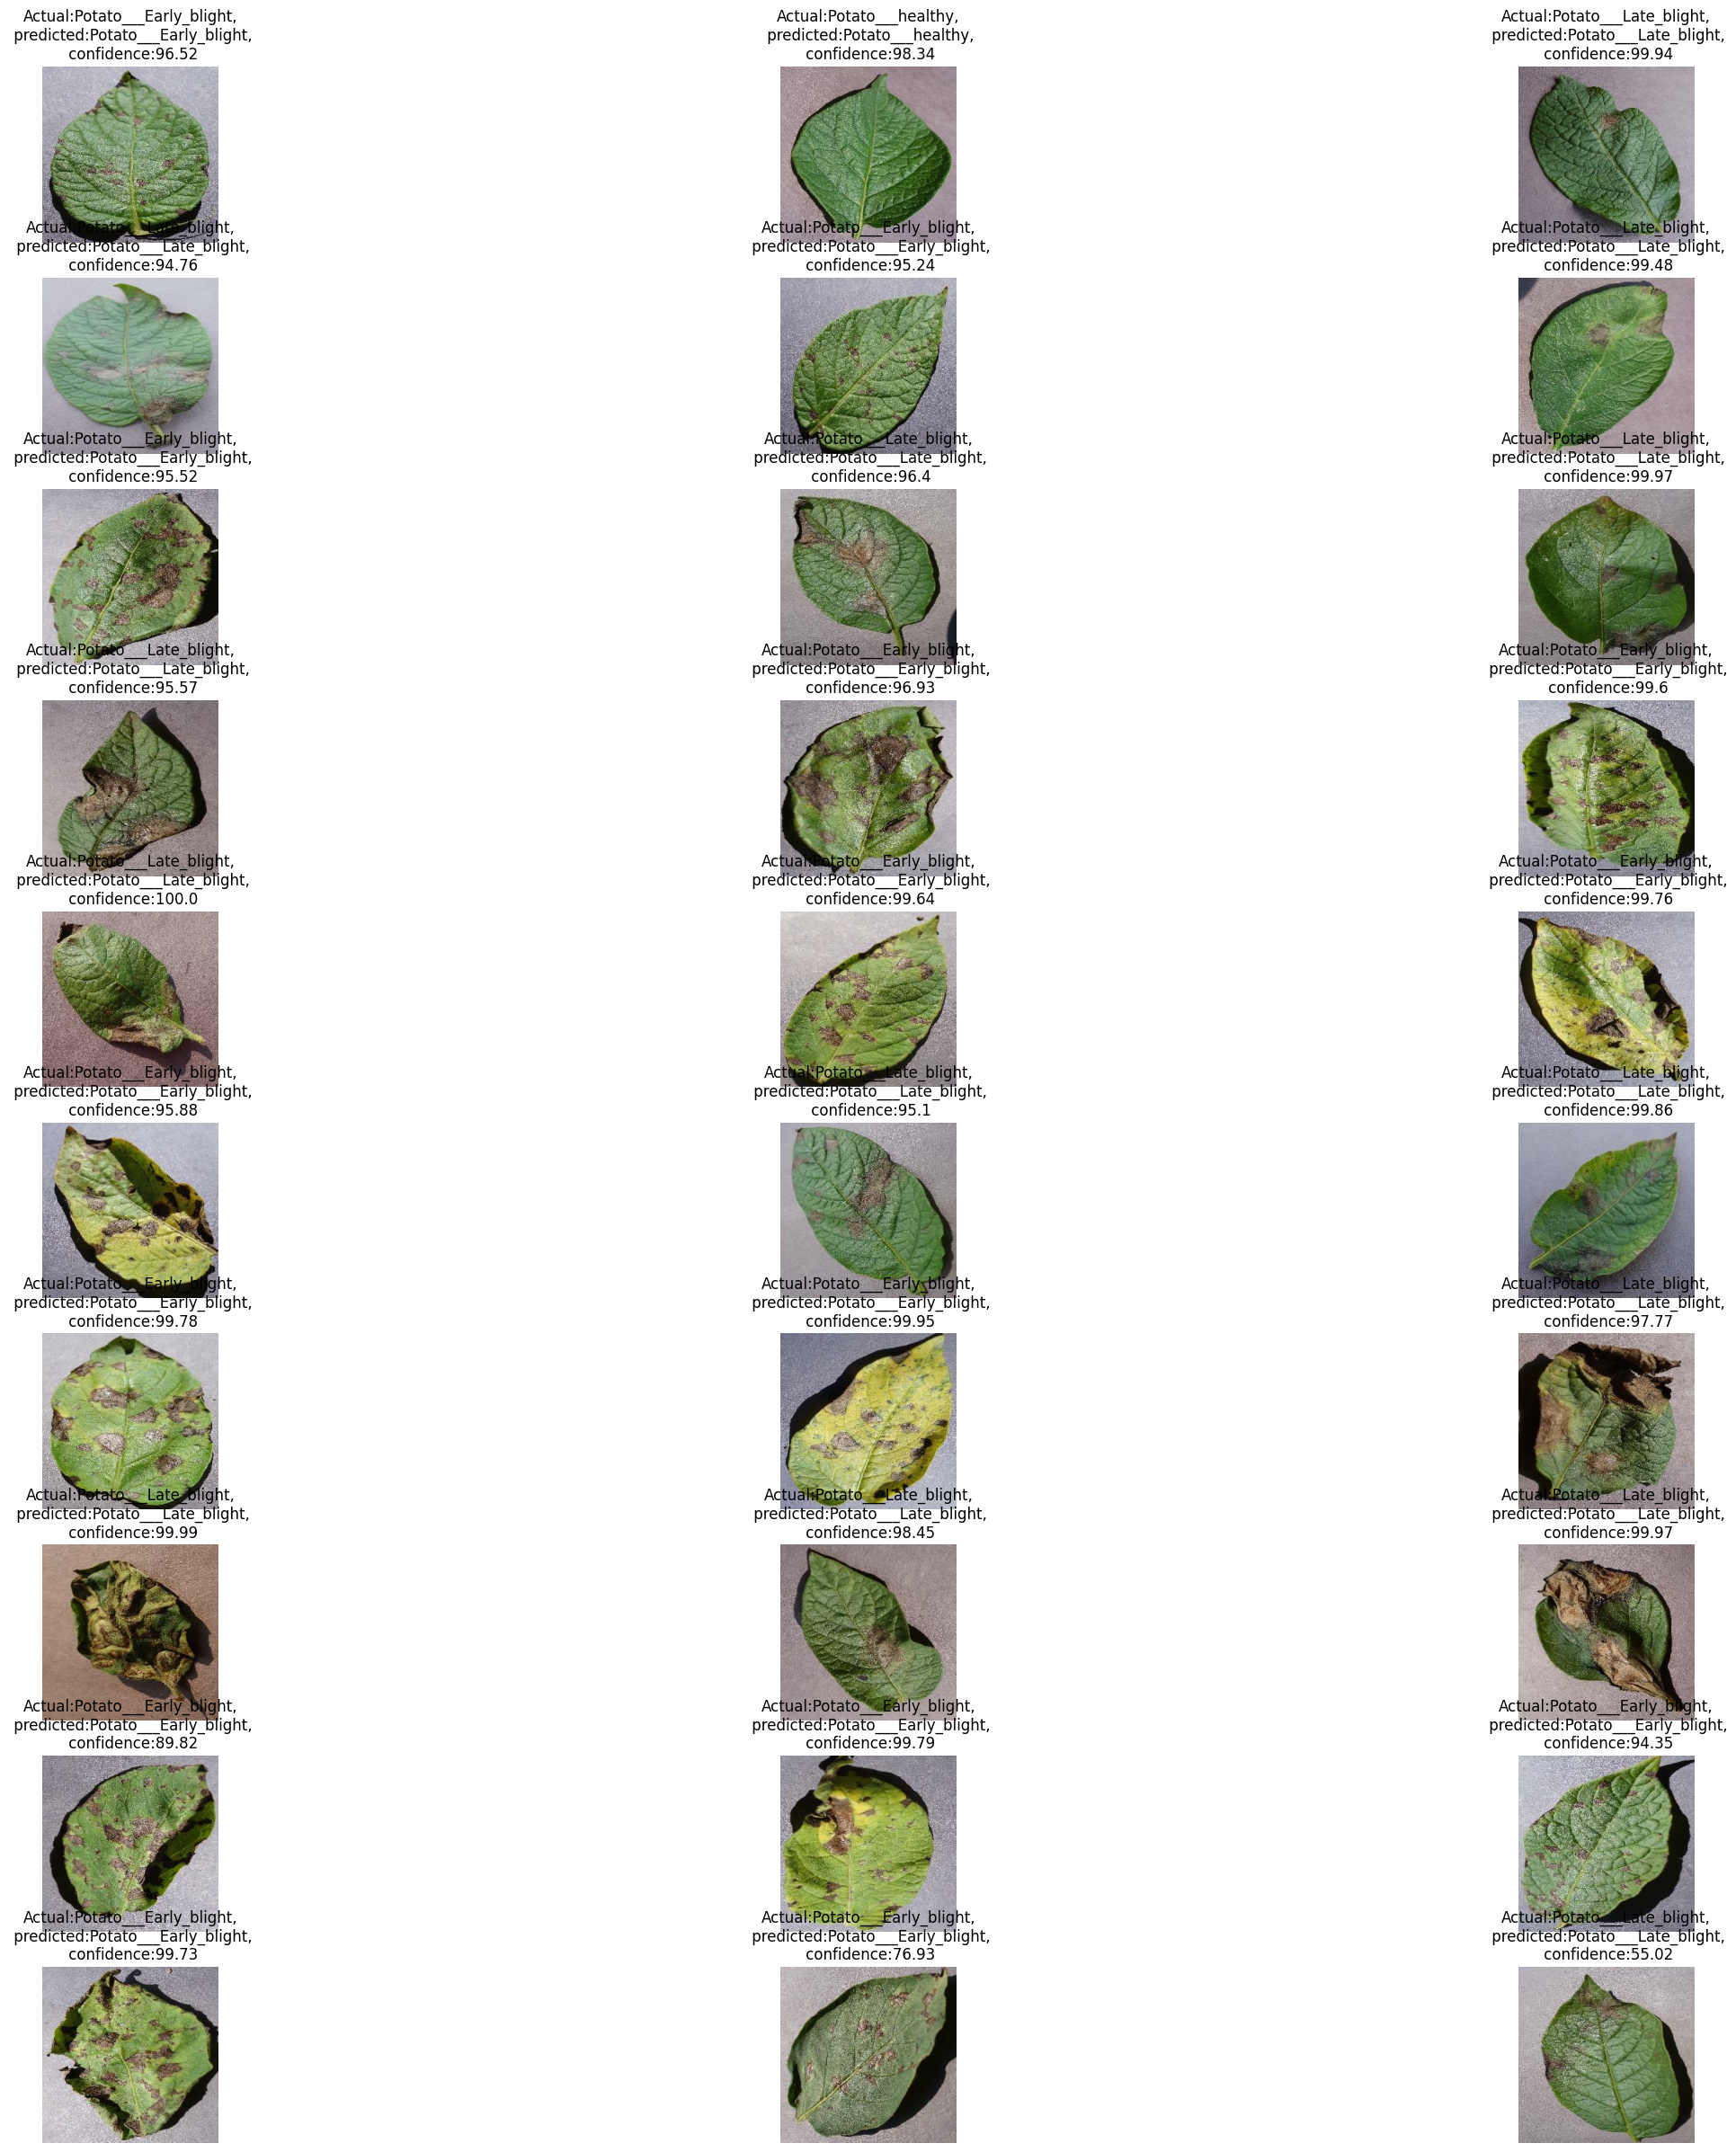

In [29]:
plt.figure(figsize=(30,30))
for images,labels in test_ds.take(1):
    for i in range (30):
        ax=plt.subplot(10,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n predicted:{predicted_class},\n confidence:{confidence}")
        plt.axis('off')


In [39]:
import os
model_versions=max([int(i[-1]) for i in os.listdir("/models")])+1
model.save(f"C:/Users/darre/OneDrive/Desktop/Darren/College Stuff/potato-disease-detection/models/{model_versions}")

INFO:tensorflow:Assets written to: C:/Users/darre/OneDrive/Desktop/Darren/College Stuff/potato-disease-detection/models/2\assets


INFO:tensorflow:Assets written to: C:/Users/darre/OneDrive/Desktop/Darren/College Stuff/potato-disease-detection/models/2\assets
